# Overview 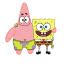

This is a webscraper retrieving images from https://www.everyframeinorder.com. This website has a repository of images, including every frame of Spongebob up through Season 6. At the time of writing, it contains images for 242 episodes. A Twitter account associated with this website can be found here: https://x.com/sbframesinorder?lang=en. The website is mostly accurate, containing a few points of overlapping images, invalid/empty entries, or incomplete coverage of an episode. Requests to the website are performed asynchronously with asyncio in conjunction with httpx and the html is parsed with Beautiful Soup. The initial cells sequentially retrieve the URLs of thumbnails for all images, storing them in a dataframe and saving them in a csv. The final cell creates distinct folders for each episode, whose name matches that of the episode excluding forbidden folder name characters. It retrieves every image associated to that episode, and saves them as PNGs within the created folder. One may kill the kernel and restart it without re-downloading images. The image dimensions are 64x64. In a forthcoming project, these images will be used to train a CNN for image classification.

In [7]:
import pandas as pd
import httpx
import aiohttp
import asyncio
import io
import csv
import time
import sys
import os

from time import perf_counter
from PIL import Image
from pathlib import Path
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import ChromeOptions

In [2]:
#Gets a list of all the episode URLS
options = ChromeOptions() 
options.add_argument("--headless=new") #opens the webpage without opening another instance of Chrome
driver = webdriver.Chrome(options=options)

driver.get("https://www.everyframeinorder.com/spongebob")
content = driver.page_source
soup = BeautifulSoup(content, "html.parser") 

episodeURLList = []
    
for link in soup.find_all('a')[5::2]:#Grabs all "URL Tails" with format like /spongebob/Sn/Em for integers n and m
    episodeURLList.append("https://www.everyframeinorder.com" + link.get('href')) 

In [ ]:
#Retrieves URLS of every thumbnail and puts it in a dataframe. Column names are episode titles.
tic = perf_counter()

thumbnailURLSdict = {}

async def get_episode_thumbnail_URLS(url, client):
    page_info = await client.get(url)
    html = page_info.text
    soup = BeautifulSoup(html, "html.parser")
    episodeTitle = soup.find('h1').text
    print("got episode " + episodeTitle)
    thumbnailURLList = []
    for line in soup.findAll(attrs={"class": "d-inline frame"}): #obtains every line in HTML with class=d-inline frame
        paragraph = line.find("img") #within that line, finds the img tag
        thumbnailURLList.append(paragraph.get("data-src"))

    titleAndThumbnailDict = {episodeTitle : thumbnailURLList}
    return titleAndThumbnailDict


def get_tasks(client):
    tasks = []
    for episodeURL in episodeURLList:
        print("Getting task " + episodeURL)
        tasks.append(asyncio.create_task(get_episode_thumbnail_URLS( episodeURL, client )))
    return tasks


async def get_all_thumbnail_URLS():
    async with httpx.AsyncClient(limits=httpx.Limits(max_connections=100, max_keepalive_connections=200), timeout=None) as client:
        tasks = get_tasks(client)
        titleAndThumbnailDictList = await asyncio.gather(*tasks)
        for titleAndThumbnail in titleAndThumbnailDictList:
            thumbnailURLSdict.update(titleAndThumbnail)


await get_all_thumbnail_URLS()

thumbnailURLSdf = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in thumbnailURLSdict.items() ]))
thumbnailURLSdf = thumbnailURLSdf.fillna('')

toc = perf_counter()

print("That took",toc - tic, "seconds")

In [49]:
#Puts all episode URLS into a CSV
thumbnailURLSdf.to_csv('thumbnailURLS.csv', encoding='utf-8')

# Start here after first usage

In [8]:
#Loading episode URLS from CSV into Dataframe. Start here after first usage.
#S02E08: Imitation Krabs contains many invalid URLs. Frames 2991 - 5292 have URLS on the webiste, but do not exist. They are extraneous entries and have been manually deleted from the csv.
thumbnailURLSdf = pd.read_csv('thumbnailURLS.csv', dtype='string')

In [9]:
thumbnailURLSdf.drop(thumbnailURLSdf.columns[0], axis=1, inplace=True)
thumbnailURLSdf.fillna(value='', inplace=True)

In [10]:
pd.set_option('max_colwidth', 400)
thumbnailURLSdf.head()

,Help Wanted,Reef Blower,Tea at the Treedome,BubbleStand,Ripped Pants,Jellyfishing,Plankton!,Naughty Nautical Neighbors,Boating School,Pizza Delivery,...,No Hat for Pat,Toy Store of Doom,Sand Castles in the Sand,Shell Shocked,Chum Bucket Supreme,Single Cell Anniversary,Truth or Square,Pineapple Fever,Chum Caverns,The Clash of Triton
0,https://frames.everyfra.me/thumbnails/spongebob/S01E01/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E02/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E03/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E04/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E05/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E06/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E07/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E08/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E09/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E10/0001.jpg,...,https://frames.everyfra.me/thumbnails/spongebob/S06E38/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E39/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E40/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E41/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E42/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E43/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E44/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E45/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E46/0001.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E47/0001.jpg
1,https://frames.everyfra.me/thumbnails/spongebob/S01E01/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E02/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E03/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E04/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E05/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E06/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E07/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E08/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E09/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E10/0002.jpg,...,https://frames.everyfra.me/thumbnails/spongebob/S06E38/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E39/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E40/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E41/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E42/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E43/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E44/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E45/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E46/0002.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E47/0002.jpg
2,https://frames.everyfra.me/thumbnails/spongebob/S01E01/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E02/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E03/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E04/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E05/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E06/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E07/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E08/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E09/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S01E10/0003.jpg,...,https://frames.everyfra.me/thumbnails/spongebob/S06E38/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E39/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E40/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E41/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E42/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E43/0003.jpg,https://frames.everyfra.me/thumbnails/spongebob/S06E44/0003.jpg

In [14]:
thumbnailURLSdf.columns[0:80]

Index(['Help Wanted', 'Reef Blower', 'Tea at the Treedome', 'BubbleStand',
       'Ripped Pants', 'Jellyfishing', 'Plankton!',
       'Naughty Nautical Neighbors', 'Boating School', 'Pizza Delivery',
       'Home Sweet Pineapple', 'Mermaidman and Barnacleboy', 'Pickles',
       'Hall Monitor', 'Jellyfish Jam', 'Sandy's Rocket', 'Squeaky Boots',
       'Nature Pants', 'Opposite Day', 'Culture Shock', 'F.U.N.',
       'MuscleBob BuffPants', 'Squidward the Unfriendly Ghost',
       'The Chaperone', 'Employee of the Month', 'Scaredy Pants',
       'I Was a Teenage Gary', 'SB-129', 'Karate Choppers', 'Sleepy Time',
       'Suds', 'Valentine's Day', 'The Paper', 'Arrgh!', 'Rock Bottom',
       'Texas', 'Walking Small', 'Fools in April', 'Neptune's Spatula',
       'Hooky', 'Mermaidman and Barnacleboy II', 'Your Shoe's Untied',
       'Squid's Day Off', 'Something Smells', 'Bossy Boots', 'Big Pink Loser',
       'Bubble Buddy', 'Dying for Pie', 'Imitation Krabs', 'Wormy',
       'Patty Hype',

In [ ]:
async def get_thumbnail(url, client, directory):
    try:
        page_info = await client.get(url)
        image_content = page_info.content
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert("RGB")
        image = image.resize((64,64))
        file_path = Path(directory, url[-15:-4].replace("/", ".") + ".png")
        image.save(file_path, "PNG", quality=90)
            
    except Exception as e:
        print("Error:", e, ". Episode: " + url[-15:-4].replace("/", "."))
        


def get_tasks(client, currentColumn):
    tasks = []
    current_directory = Path("C:/Users/19368/Desktop/Gary/EveryFrameOfSpongebob/" + currentColumn.replace("?", ""))
    
    if not current_directory.exists():
        os.mkdir(current_directory)
    
    checkList = os.listdir(current_directory)
    for url in thumbnailURLSdf[currentColumn]:
        currentImageFileName = url[-15:-4].replace("/", ".") + ".png"
        if currentImageFileName in checkList:#if the image is already downloaded, move onto the next one
            continue
        if url:#makes sure that the url isn't empty
            tasks.append(asyncio.create_task(get_thumbnail(url , client, current_directory)))
    return tasks


async def get_all_thumbnails(currentColumn):
    async with httpx.AsyncClient(limits=httpx.Limits(max_connections=32, max_keepalive_connections=100), timeout=None) as client:
        tasks = get_tasks(client, currentColumn)
        await asyncio.gather(*tasks)


for column in thumbnailURLSdf.columns[0:80]:
    await get_all_thumbnails(column)
    print(column + " completed!")

Help Wanted completed!
Reef Blower completed!
Tea at the Treedome completed!
BubbleStand completed!
Ripped Pants completed!
Jellyfishing completed!
Plankton! completed!
Naughty Nautical Neighbors completed!
Boating School completed!
Pizza Delivery completed!
Home Sweet Pineapple completed!
Mermaidman and Barnacleboy completed!
Pickles completed!
Hall Monitor completed!
Jellyfish Jam completed!
Sandy's Rocket completed!
Squeaky Boots completed!
Nature Pants completed!
Opposite Day completed!
Culture Shock completed!
F.U.N. completed!
MuscleBob BuffPants completed!
Squidward the Unfriendly Ghost completed!
The Chaperone completed!
Employee of the Month completed!
Scaredy Pants completed!
I Was a Teenage Gary completed!
SB-129 completed!
Karate Choppers completed!
Sleepy Time completed!
Suds completed!
Valentine's Day completed!
The Paper completed!
Arrgh! completed!
Rock Bottom completed!
Texas completed!
Walking Small completed!
Fools in April completed!
Neptune's Spatula completed!
Hoo